# MultiFrameSR use case

The MultiFrame Super Resolution (MFSR) use case is build to compare the image quality between different MFSR solutions.
A MFSR algorithm inputs several frames of the same scene and outputs a single frame at a greater resolution.
These are the methods that are being compared in the use case:


1. Adaptative Gaussian Kernels (AGK)
2. WarpWaves (WARPW)
3. Multi-scale Residual Network (MSRN)
4. HighResNet (HRN)

A use case in IQF usally involves wrapping a training within mlflow framework. In this case we assess quality on the solutions offered by the different Dataset Modifiers which are the MFSR algorithms.
Similarity metrics against the Ground Truth are used.

In [ ]:
import os
import shutil
import piq
import torch

from glob import glob
from scipy import ndimage
from typing import Any, Dict, Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt

from iquaflow.datasets import DSModifier, DSWrapper,DSModifier_jpg
from iquaflow.experiments import ExperimentInfo, ExperimentSetup
from iquaflow.experiments.experiment_visual import ExperimentVisual
from iquaflow.experiments.task_execution import PythonScriptTaskExecution
from iquaflow.metrics import BBDetectionMetrics, SNRMetric
from iquaflow.metrics import SharpnessMetric as RERMetric

In [ ]:
from custom_iqf import DSModifierMFSR, SimilarityMetricsForMFSR, SlicedWassersteinMetric

In [3]:
#Define name of IQF experiment
experiment_name = "xview-test-v5-200samples"

#Define path of the original(reference) dataset
data_path = "./xviewds/xview-ds/test"

#DS wrapper is the class that encapsulate a dataset
ds_wrapper = DSWrapper(data_path=data_path)

#Define path of the training script
python_ml_script_path = 'custom_train.py'

In [4]:
#List of modifications that will be applied to the original dataset:

ds_modifiers_list = [
    DSModifierMFSR( params={
        'algo':algo,
        'zoom': 3,
        'n_jobs': 15
    } )
    for algo in ['fake','warpw_v0','warpw','agk','msrn']
]


ds_modifiers_list += [
    DSModifierMFSR( params={
        'algo':algo,
        'zoom': 3,
        'config':conf,
        'model':model
    } )
    for algo, conf, model in zip(
        [
            'hrn',
            'hrn',
            'hrn',
            'hrn',
            'hrn'
        ],
        [
            "hrn_exp27.json",
            "hrn_exp27-histmatch-v5.json",
            "hrn_exp27-histmatch-v6.json",
            "hrn_exp27+inria-histmatch-v5.json",
            "hrn_exp27+inria-histmatch-v6.json"
        ],
        [
            "exp27/HRNet_30.pth",
            "exp27-histmatch-v5/HRNet.pth",
            "exp27-histmatch-v6/HRNet.pth",
            "exp27+inria-histmatch-v5/HRNet.pth",
            "exp27+inria-histmatch-v6/HRNet.pth"
        ]
    )
]

n_jobs > 1 Not supported yet for algorithm fake,
changing it to params['n_jobs']=1 ...
n_jobs > 1 Not supported yet for algorithm warpw,
changing it to params['n_jobs']=1 ...
n_jobs > 1 Not supported yet for algorithm msrn,
changing it to params['n_jobs']=1 ...
single_frame_sr/SISR_MSRN_X2_BICUBIC.pth
https://image-quality-framework.s3-eu-west-1.amazonaws.com/iq-mfsr-use-case/models/weights/single_frame_sr/SISR_MSRN_X2_BICUBIC.pth
Loaded MSRN  /tmp/tmpsndujrla/model.pth
exp27/HRNet_30.pth
https://image-quality-framework.s3-eu-west-1.amazonaws.com/iq-mfsr-use-case/models/config/hrn_exp27.json
https://image-quality-framework.s3-eu-west-1.amazonaws.com/iq-mfsr-use-case/models/weights/exp27/HRNet_30.pth
exp27-histmatch-v5/HRNet.pth
https://image-quality-framework.s3-eu-west-1.amazonaws.com/iq-mfsr-use-case/models/config/hrn_exp27-histmatch-v5.json
https://image-quality-framework.s3-eu-west-1.amazonaws.com/iq-mfsr-use-case/models/weights/exp27-histmatch-v5/HRNet.pth
exp27-histmatch-v6/HRNet

In [5]:
# Task execution executes the training loop
# In this case the training loop is an empty script,
# this is because we evaluate the performance directly on the result of the modifiers.
task = PythonScriptTaskExecution( model_script_path = python_ml_script_path )

#Experiment definition, pass as arguments all the components defined beforehand
experiment = ExperimentSetup(
    experiment_name=experiment_name,
    task_instance=task,
    ref_dsw_train=ds_wrapper,
    ds_modifiers_list=ds_modifiers_list,
    repetitions=1
)

### Execution

The number of runs are all the combinations between repetitions, modifiers list as well as hyper parameter changes.

(you can skip this step in demo pre-executed datasets)

In [5]:
experiment.execute()

## Metrics

ExperimentInfo is used to retrieve all the information of the whole experiment. 
It contains built in operations but also it can be used to retrieve raw data for futher analysis. Its instance can also be used to apply metrics per run. Some custum metrics are presented. They where build by inheriting **Metric** from **iquaflow.metrics**.

(you can skip this step in demo pre-executed datasets)

In [6]:
# ExperimentInfo is used to retrieve all the information of the whole experiment. 
# It contains built in operations but also it can be used to retrieve raw data for futher analysis

experiment_info = ExperimentInfo(experiment_name)

In [7]:
print('Calculating similarity metrics...')

_ = experiment_info.apply_metric_per_run(
    SimilarityMetricsForMFSR( experiment_info, cut=12//2 ),
    ds_wrapper.json_annotations,
)

print('Calculating Sliced Wasserstein Distance Metric...')

win = 128

_ = experiment_info.apply_metric_per_run(
    SlicedWassersteinMetric(
        experiment_info,
        ext                  = 'png',
        n_pyramids           = 2,
        slice_size           = 7,
        n_descriptors        = win*2,
        n_repeat_projection  = win,
        proj_per_repeat      = 4,
        device               = 'cpu',
        return_by_resolution = False,
        pyramid_batchsize    = win
    ),
    ds_wrapper.json_annotations,
)

print('Calculating RER Metric...')

_ = experiment_info.apply_metric_per_run(
    RERMetric(
        experiment_info,
        ext="png",
        window_size=64,
    ),
    ds_wrapper.json_annotations,
)

print('Calculating SNR Metric...')

__ = experiment_info.apply_metric_per_run(
     SNRMetric(
         experiment_info,
         ext="png"
     ),
     ds_wrapper.json_annotations,
 )

In [7]:
df = experiment_info.get_df(
    ds_params=["modifier"],
    metrics=[
        'ssim','psnr','gmsd','mdsi','fid','swd',"snr_median", "snr_mean", "snr_std",
        'fid','FWHM_Y', 'MTF_NYQ_X', 'MTF_halfNYQ_X', 'MTF_halfNYQ_other',
         'RER_Y', 'RER_other', 'RER_X', 'FWHM_other', 'MTF_NYQ_other'],
    dropna=False
)

# Visualize

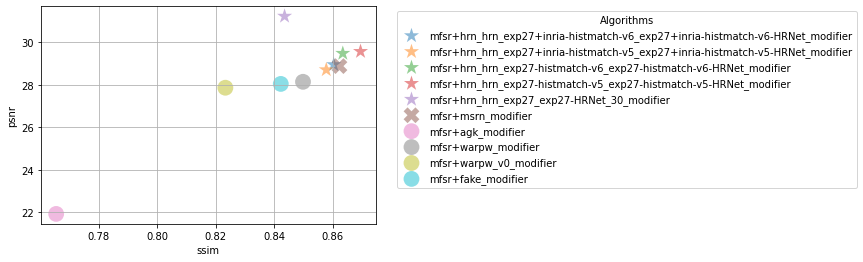

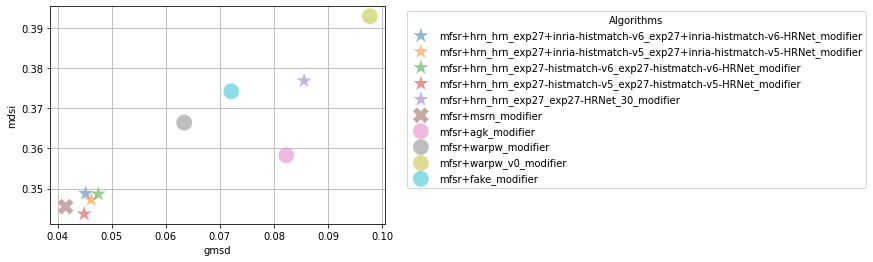

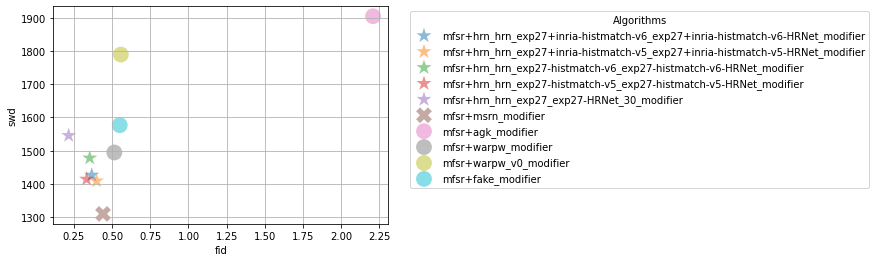

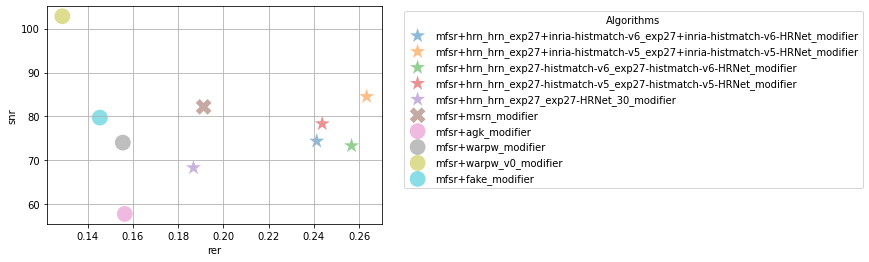

In [8]:
from visual_comparison import scatter_plots

scatter_plots(df)

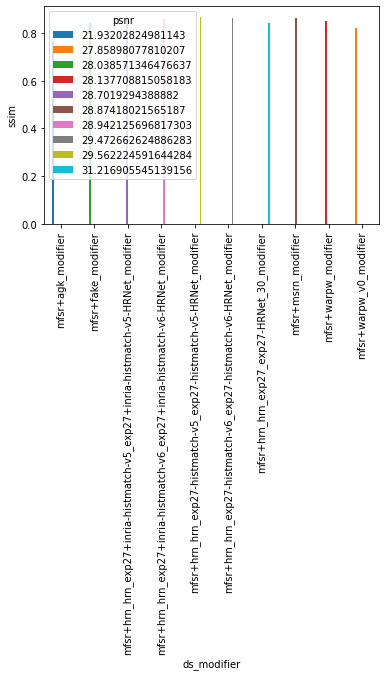

In [9]:
ev = ExperimentVisual(df, None)

ev.visualize(
    plot_kind="bars",
    xvar="ds_modifier",
    yvar="ssim",
    legend_var='psnr',
    title=""
)

SAMPLE 0 *******************************************************************************************************************************************************************************


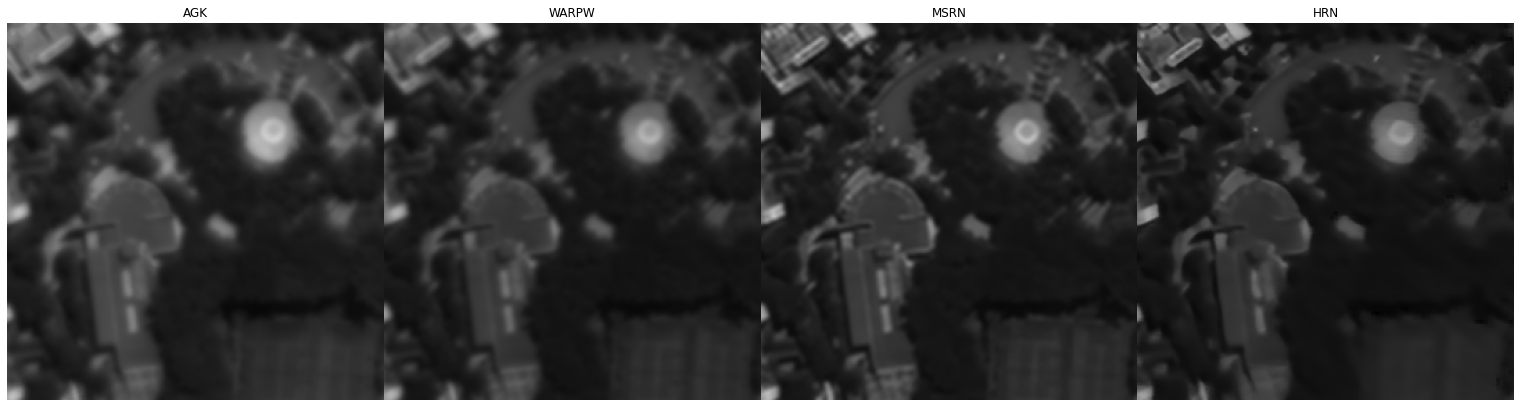

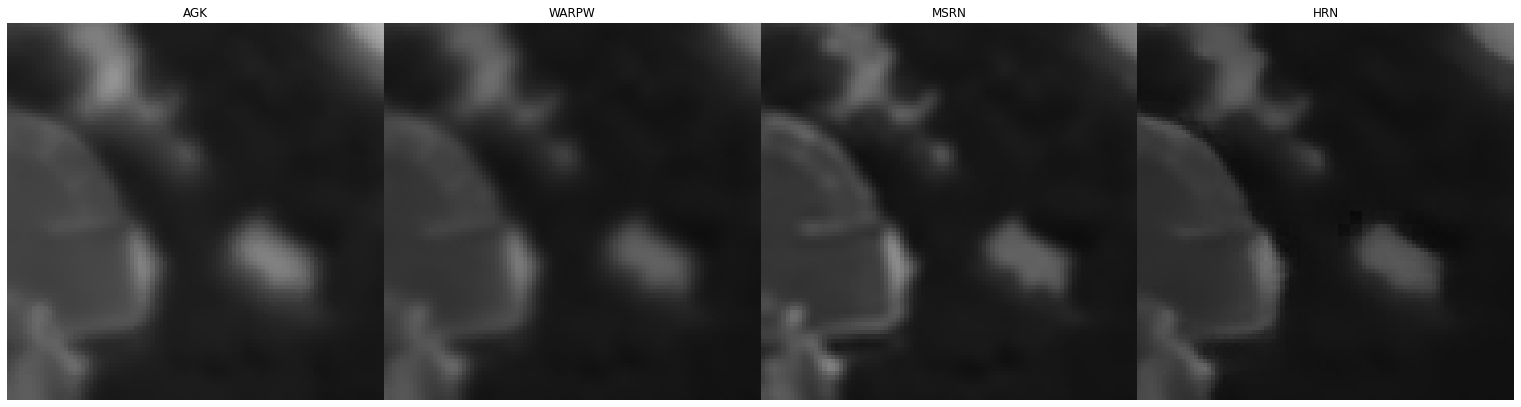

SAMPLE 1 *******************************************************************************************************************************************************************************


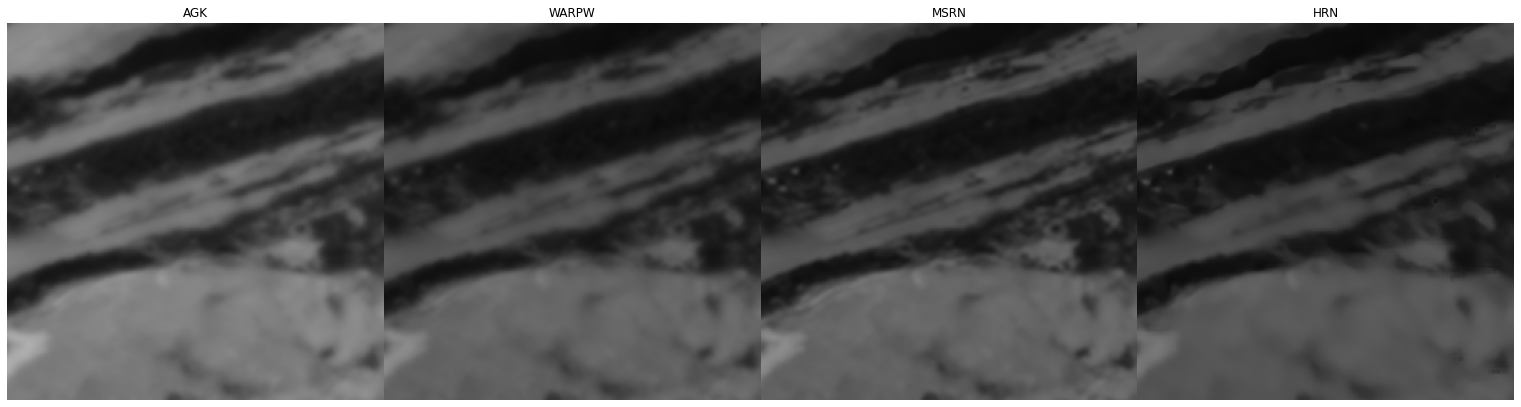

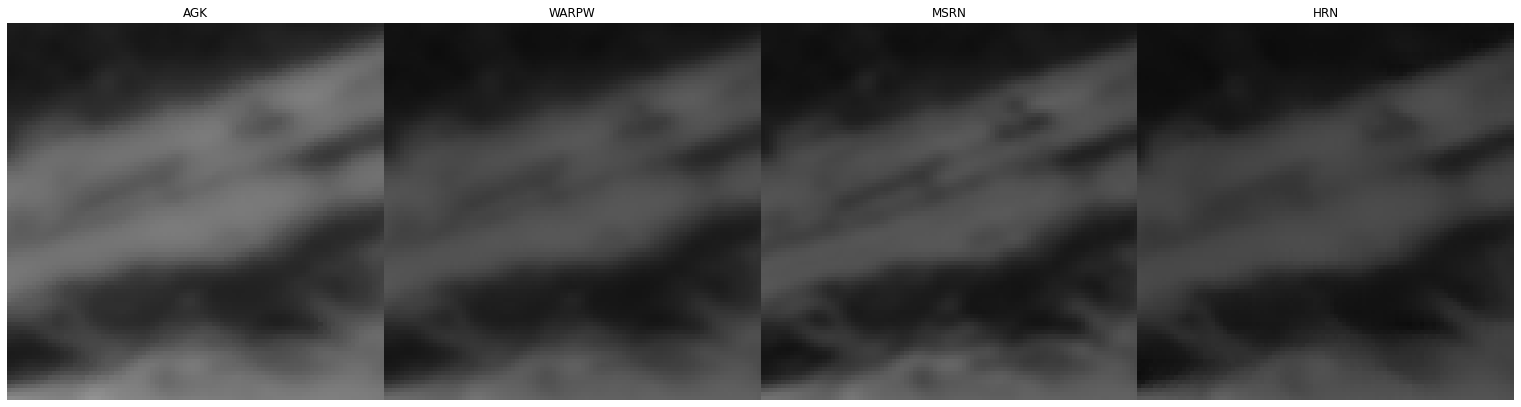

SAMPLE 2 *******************************************************************************************************************************************************************************


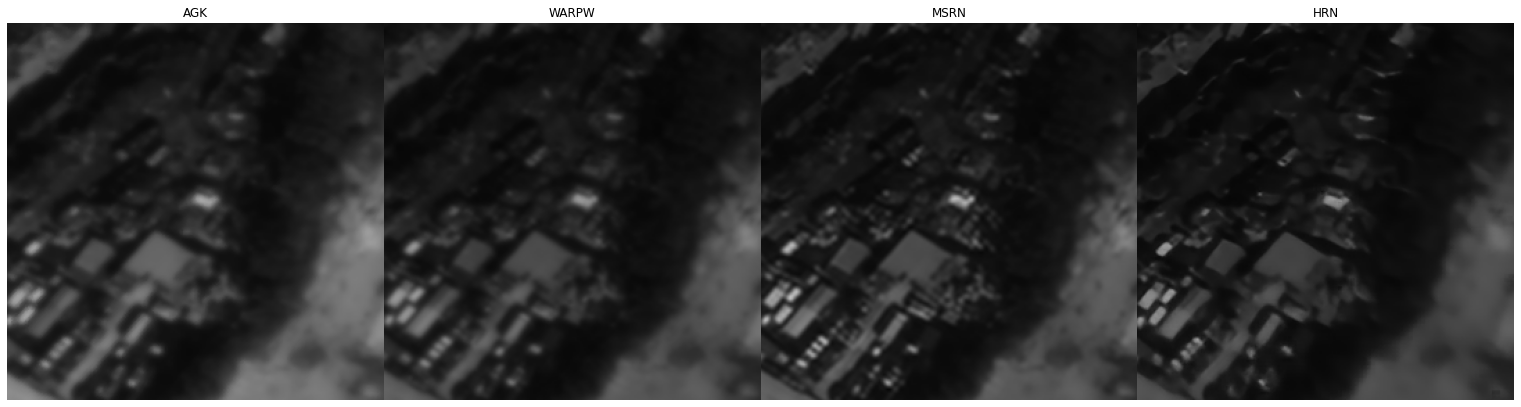

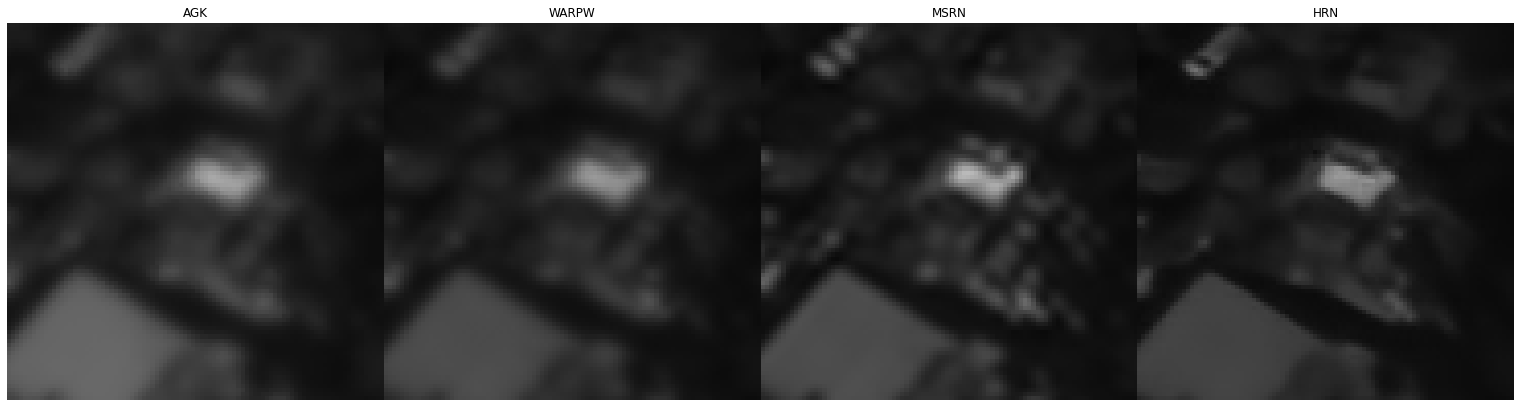

SAMPLE 3 *******************************************************************************************************************************************************************************


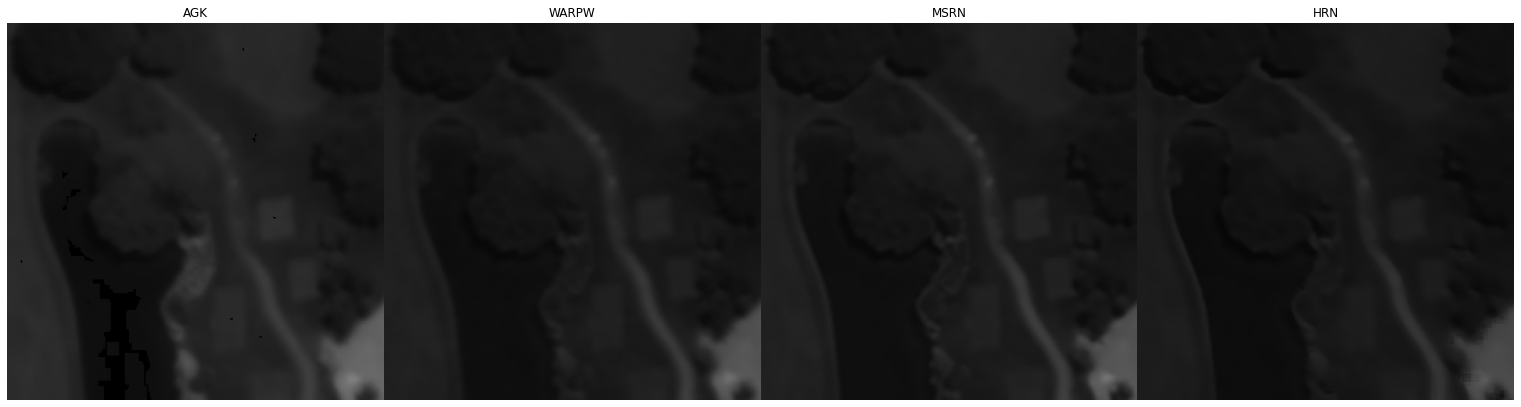

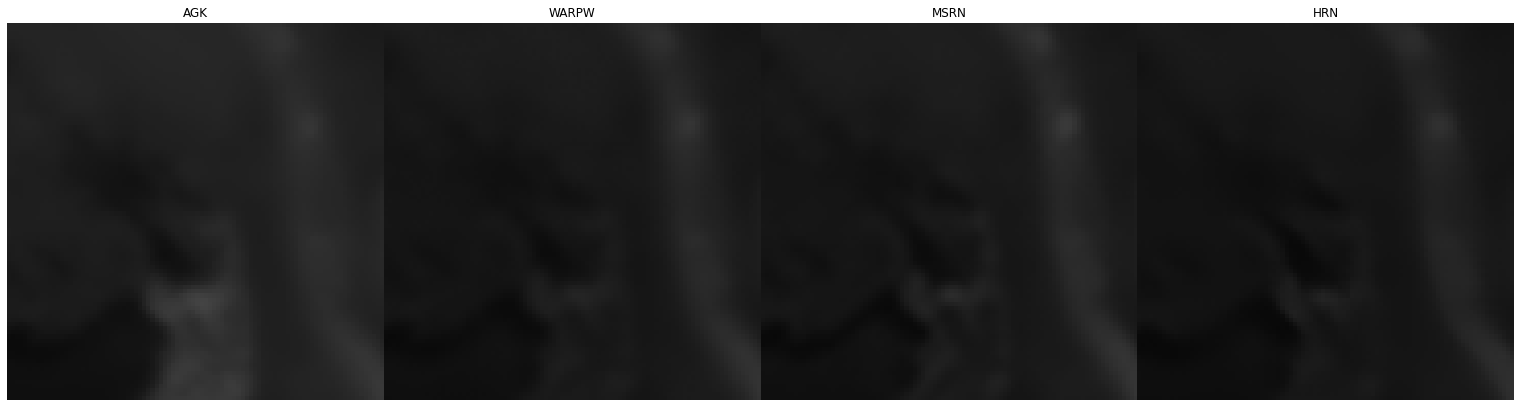

SAMPLE 4 *******************************************************************************************************************************************************************************


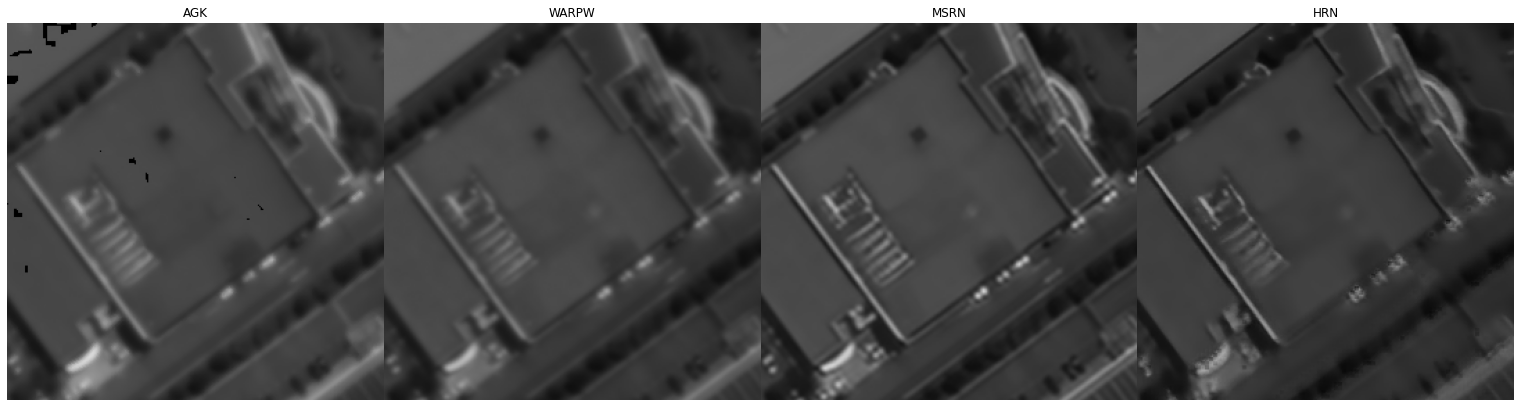

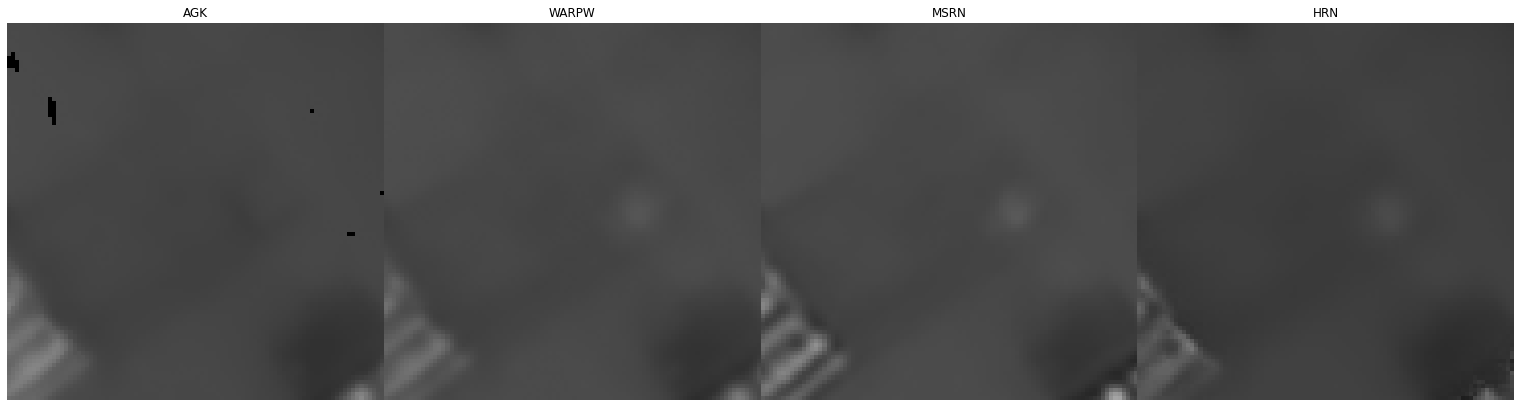

SAMPLE 5 *******************************************************************************************************************************************************************************


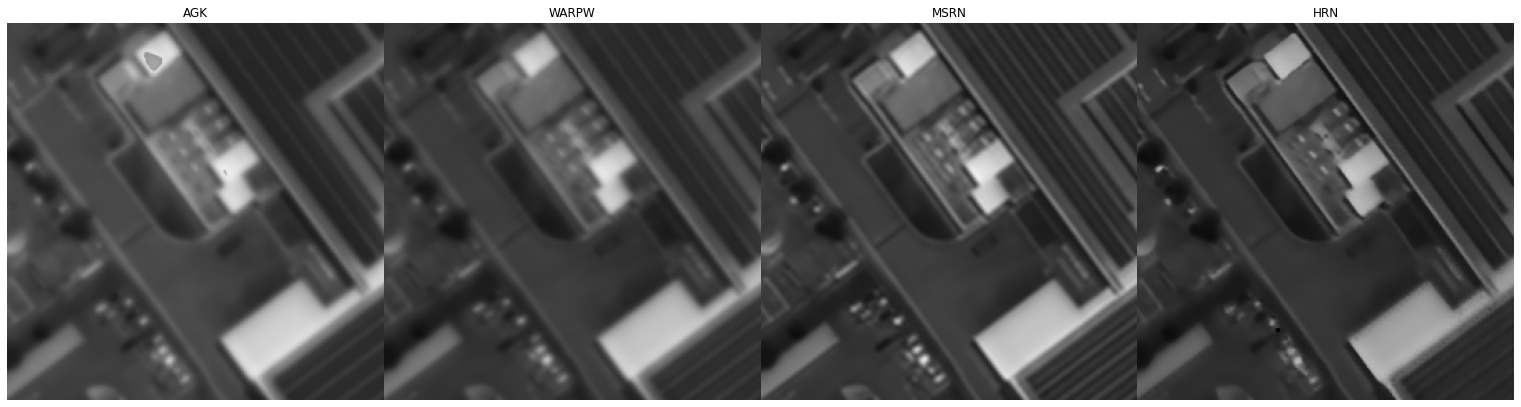

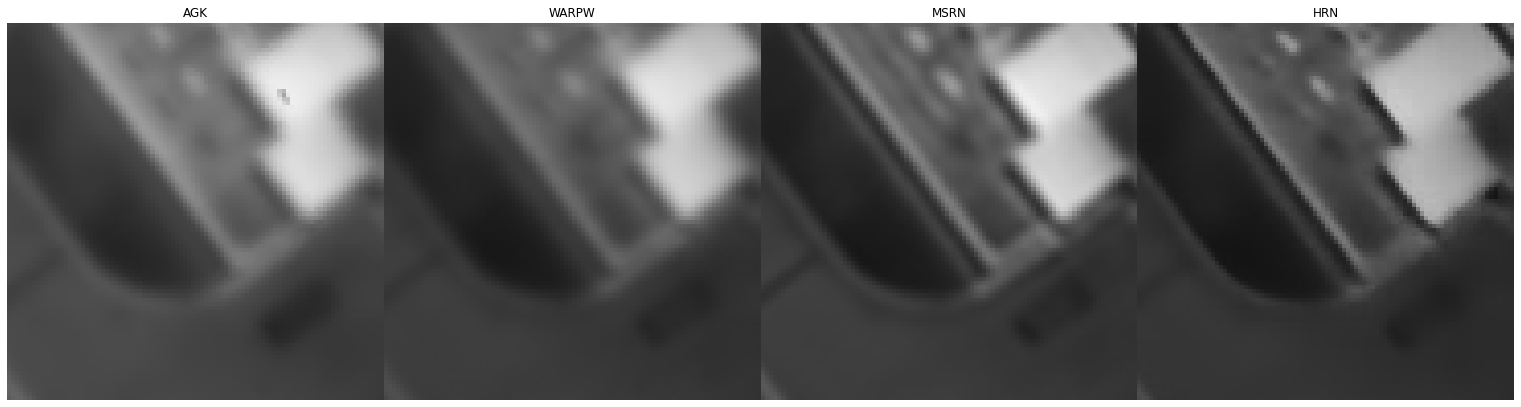

SAMPLE 6 *******************************************************************************************************************************************************************************


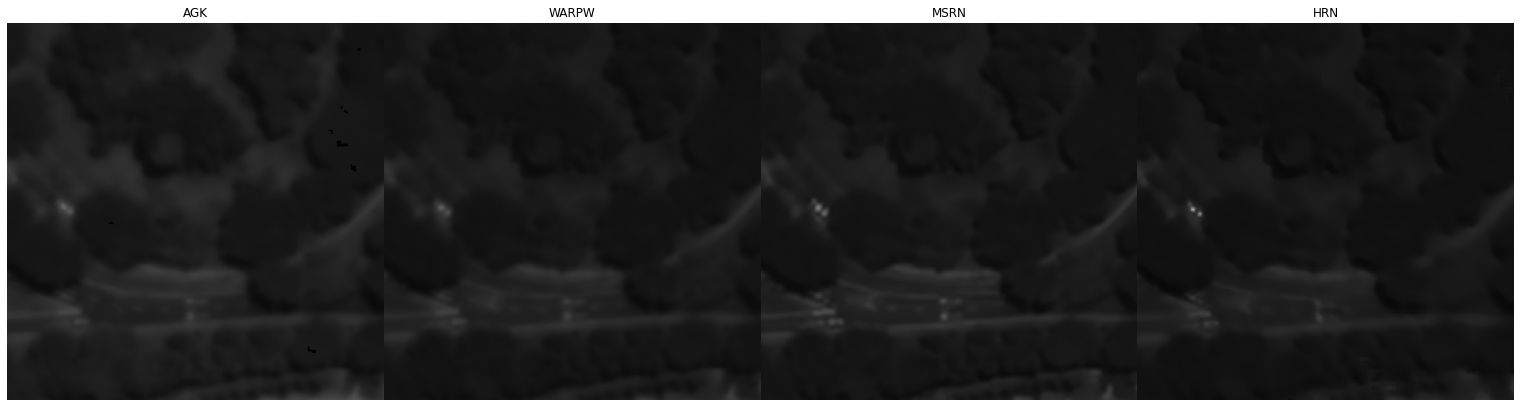

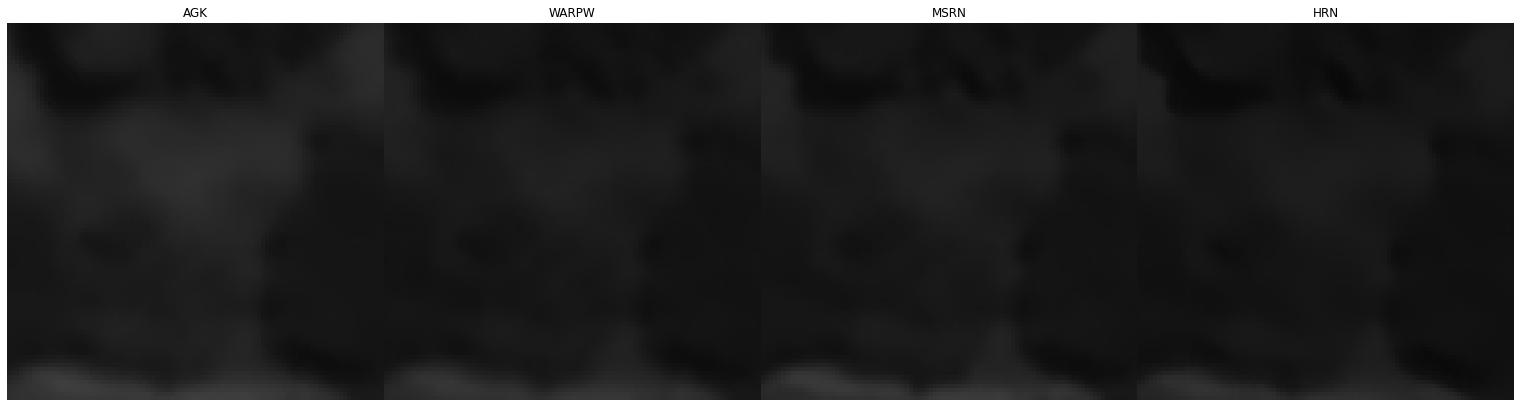

SAMPLE 7 *******************************************************************************************************************************************************************************


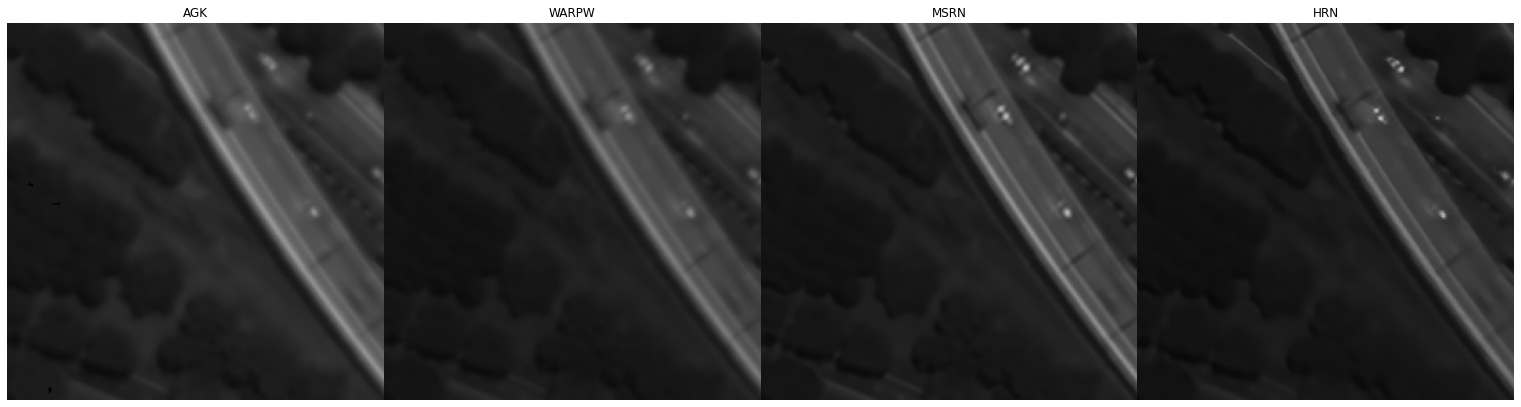

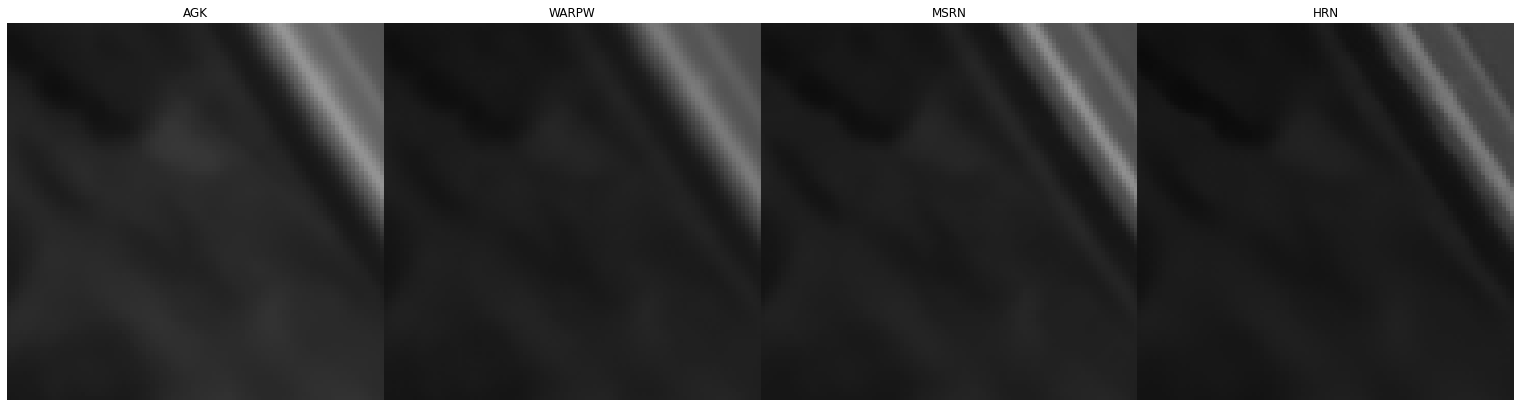

SAMPLE 8 *******************************************************************************************************************************************************************************


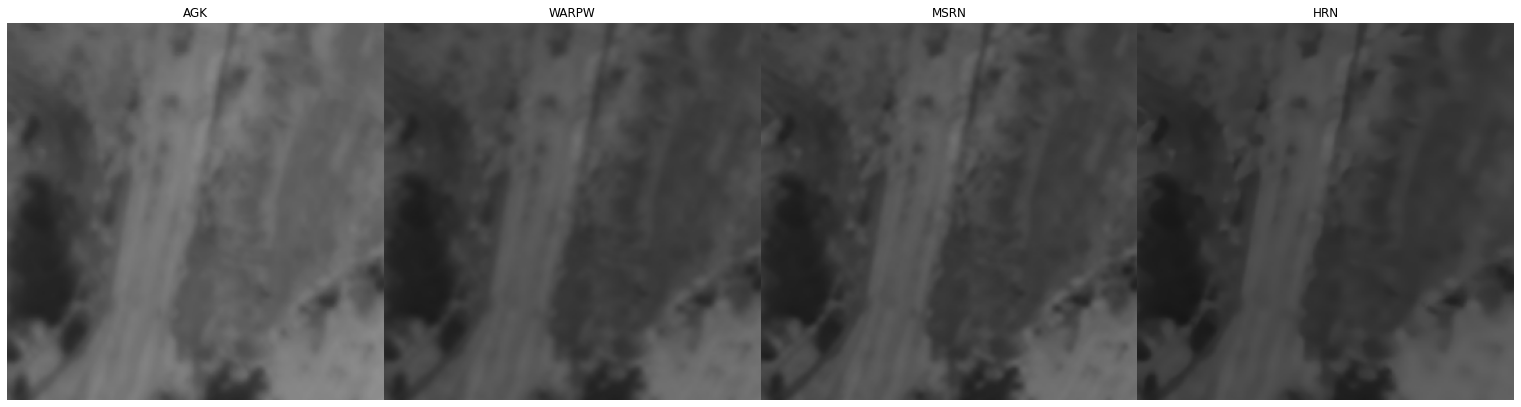

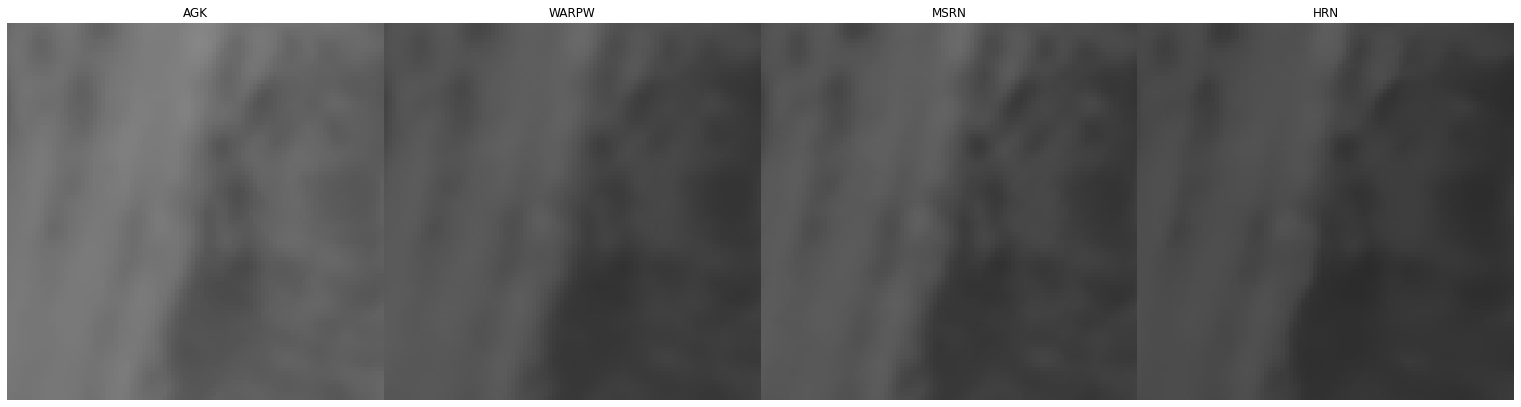

SAMPLE 9 *******************************************************************************************************************************************************************************


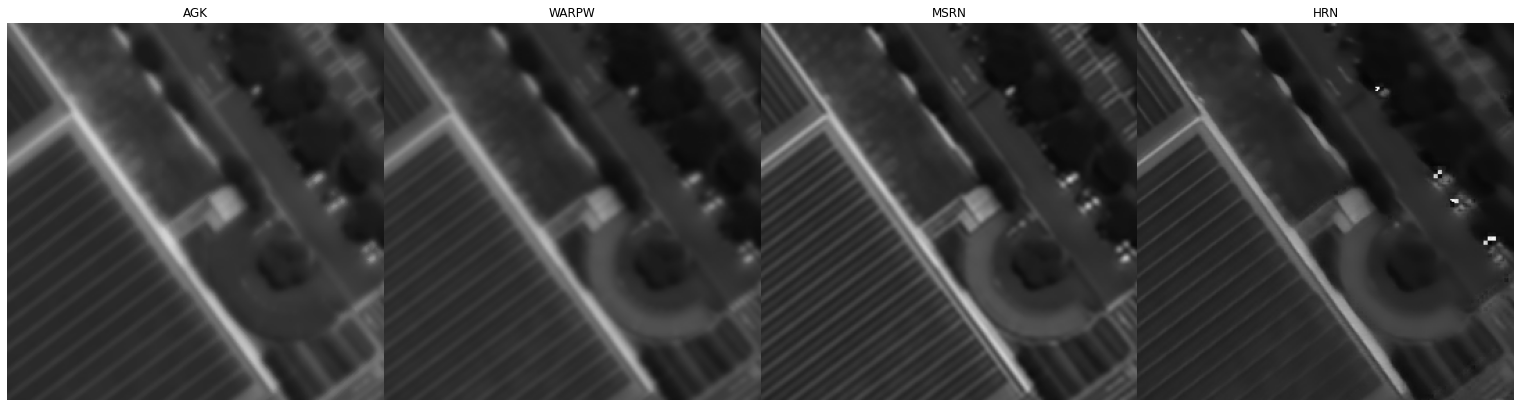

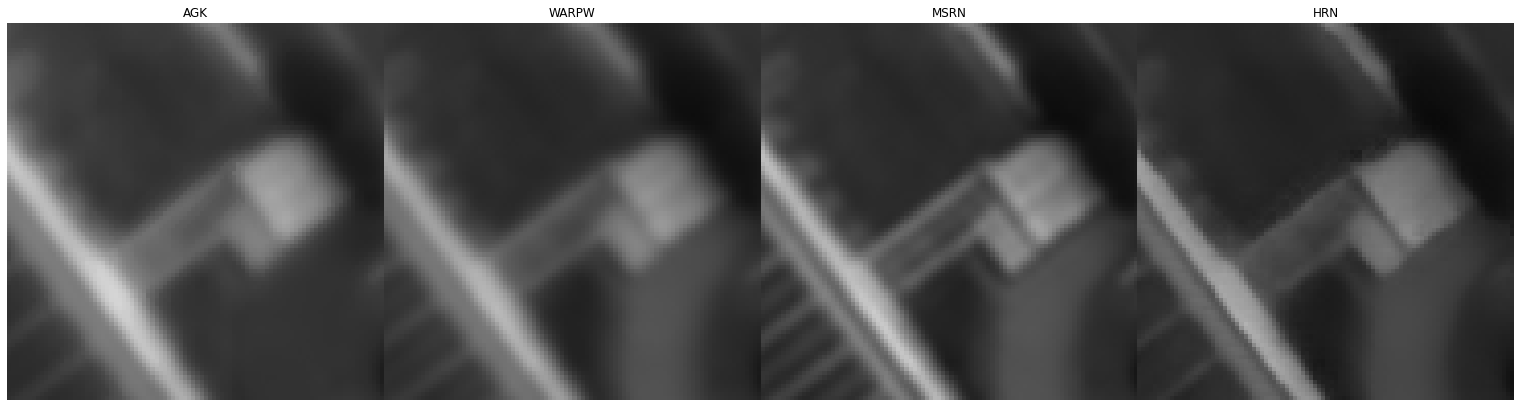

SAMPLE 10 *******************************************************************************************************************************************************************************


In [ ]:
from visual_comparison import visual_comp

visual_comp()